## Simulation for biallelic dynamics of SCN1A

In [1]:
# The following section only needs to be executed when running off of google drive

# from google.colab import drive
# drive.mount('/content/drive')

# This needs to be run only once at the beginning to access the models
#-------------------------------------------------------------------------------
!pip install --upgrade git+https://github.com/roschkoenig/SodMod.git@Single_Cell_Playground


  Cloning https://github.com/roschkoenig/SodMod.git (to revision Single_Cell_Playground) to /tmp/pip-req-build-x7wx6rxs
  Running command git clone -q https://github.com/roschkoenig/SodMod.git /tmp/pip-req-build-x7wx6rxs
  Running command git checkout -b Single_Cell_Playground --track origin/Single_Cell_Playground
  Switched to a new branch 'Single_Cell_Playground'
  Branch 'Single_Cell_Playground' set up to track remote branch 'Single_Cell_Playground' from 'origin'.
  Created wheel for sodmod: filename=sodmod-0.1-cp36-none-any.whl size=9887 sha256=38395b80617881af45c29e1009d3f7838831c1783cd7caa969deca7cf7aaef66
  Stored in directory: /tmp/pip-ephem-wheel-cache-jn1atrw9/wheels/f5/c8/ed/7143b20ea12c7f48f261b4022f2aad8eb6987daa2ebd74ca23
Successfully built sodmod
  Found existing installation: sodmod 0.1
    Uninstalling sodmod-0.1:
      Successfully uninstalled sodmod-0.1


In [0]:
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
from scipy.integrate import odeint
from torch import multiprocessing as mp
from itertools import repeat
from IPython.display import set_matplotlib_formats
from google.colab import files
import matplotlib as mpl

import sodmod as sm
from sodmod import params as pr
from sodmod import cells as cl
from sodmod import incurr as ic

In [0]:
# Manual definitions
#===============================================================================
# Simulations
#-------------------------------------------------------------------------------
V0          = -80
steps       = 150                         # Number of simulations to be ru
ctyp        = 'IN'                        # Cell type to be used 'IN', 'PY', 'RE'
conds       = ['WT37', 'AS37', 'TI37']    # Conditions to be modelled
cols        = ['k', 'b', 'r']             # Colours for plotting 
no_parallel = False
whichplot   = 'ramp'               # 'bifurcation', 'ramp', or 'phasespace'                    

# Define parameters for the selected plot type
#-------------------------------------------------------------------------------
if whichplot == 'bifurcation':
  ptype      = 'bifurcation'
  paradigm   = 'constant'
  T          = np.linspace(0,250,5000)

if whichplot == 'ramp':
  ptype      = 'timeseries'
  paradigm   = 'ramp'              
  T          = np.linspace(0,1000,10000) 

if whichplot == 'phasespace':
  ptype      = 'phasespace'
  paradigm   = 'constant'
  T          = np.linspace(0, 250, 5000) 
  
# Initial conditions
#-------------------------------------------------------------------------------
np.random.seed(1000)


################################## ODE Solver ##################################

#===============================================================================
# Simulation executor
#===============================================================================
def runsim(i_scl, conds, cell, V0, Y0 = None, paradigm='constant'):
  Vy    = {}

  # Run simulation across conditions
  #-------------------------------------------------------------------------------  
  for ci in range(len(conds)):
    par       = pr.params(conds[ci], i_scl, ctyp, paradigm)
    if Y0 == None:  
      y0    = np.random.rand(len(par['snames']))
      y0[0] = V0
    else:           y0 = Y0[conds[ci]][-1,:]
    Vy.update({conds[ci]:odeint(cell, y0, T, args=(par,))})

  return Vy


############################### Plotting Routines ##############################
#===============================================================================
# Time series plots
#===============================================================================
def plot_timeseries(Vy, I_scl, ctyp, Nplots = 0, paradigm='constant'):

  if Nplots == 0: Nplots = len(Vy)
  conds = list(Vy[0].keys())

  # Set up plot
  #--------------------------------------------------------------------
  fig, ax = plt.subplots(Nplots+1,1, figsize=(24, Nplots*6))
  plotid  = 0

  for i in range(0,len(Vy),round(len(Vy)/Nplots)):
    
    for ci in range(len(conds)):
      cond = conds[ci]
      V    = Vy[i][cond][:,0]

      # Do the plotting
      #------------------------------------------------------------
      if Nplots == 1: 
        ax[plotid].plot(T, V-ci*100, cols[ci], label=conds[ci])
        ax[plotid].set_title("Max Input current " + str(I_scl))
        ax[plotid].legend()
      else:
        ax[plotid].plot(T, V-ci*100, cols[ci], label = conds[ci]) 
        ax[plotid].set_title("Input current" + str(I_scl[i]))
        ax[plotid].legend()

    plotid = plotid + 1
    ax[plotid].plot(T,[ic.Id(t,paradigm) for t in T])
    


#===============================================================================
# Phase space plots
#===============================================================================
def plot_phasespace(Vy, I_scl, ctyp, states = ['Vm', 'm_Na'], Nplots = 0):

  if Nplots == 0: Nplots = len(Vy)
  conds = list(Vy[0].keys())
  
  # Set up plot
  #--------------------------------------------------------------------
  fig, ax = plt.subplots(2,len(conds), figsize=(12*len(conds), 12))
  testpar = pr.params(typ = ctyp)

  for ci in range(len(conds)):
    if ci == 0: cmap = plt.get_cmap('Greys')
    if ci == 1: cmap = plt.get_cmap('Blues')
    if ci == 2: cmap = plt.get_cmap('Reds')
    ndcmap = cmap(np.linspace(0,1,Nplots))

    setall = [i for i in range(0,len(Vy),int(np.floor(len(Vy)/Nplots)))]
    set1 = np.intersect1d(np.where(np.log(I_scl) > -1)[0], np.where(np.log(I_scl) < 1)[0])

    k = 0  
    for i in setall:
      cond = conds[ci]
      s0   = Vy[i][cond][4500:5000,testpar["snames"].index(states[0])]
      s1   = Vy[i][cond][4500:5000,testpar["snames"].index(states[1])]

      # Do the plotting
      #------------------------------------------------------------
      ax[0,ci].plot(s0, s1, cols[ci], color=ndcmap[k,:]) 
      ax[0,ci].set_title(cond + "Input current " + str(I_scl[i]))

      k = k + 1
    norm = mpl.colors.Normalize(vmin=np.log(I_scl[0]), vmax=np.log(I_scl[-1]))
    cb   = mpl.colorbar.ColorbarBase(ax[1,ci], cmap=cmap, norm=norm, 
                                   orientation='horizontal')
  
#===============================================================================
# Bifurcation plots
#===============================================================================
def plot_bifurcation(Vy_fwd, Vy_bwd, I_fwd, I_bwd, ctyp, Nplots = None, direction = [0,1]):
  if Nplots == None: Nplots = len(Vy_fwd)
  conds  = list(Vy_fwd[0].keys())

  # Set up plot
  #--------------------------------------------------------------------
  fig, ax = plt.subplots(len(conds),1, figsize=(24,6*len(conds)))
  testpar = pr.params(typ = ctyp)

  plotid = 0
  for ci in range(len(conds)):
    for i in range(0,len(Vy_fwd),round(len(Vy_fwd)/Nplots)):

      cond = conds[ci]
      f    = np.zeros([2,1])
      b    = np.zeros([2,1])
      i_fwd    = np.multiply([1,1],np.log(I_fwd[i]))
      i_bwd    = np.multiply([1,1],np.log(I_bwd[i]))  

      f[0] = np.min(Vy_fwd[i][cond][1000:5000,0])
      f[1] = np.max(Vy_fwd[i][cond][1000:5000,0])

      b[0] = np.min(Vy_bwd[i][cond][1000:5000,0])
      b[1] = np.max(Vy_bwd[i][cond][1000:5000,0])

      # Do the plotting
      #------------------------------------------------------------

      if 0 in direction:  ax[plotid].scatter(i_fwd, f, color=cols[ci])
      if 1 in direction:  ax[plotid].scatter(i_bwd, b, color=cols[ci], facecolor='none') 

    plotid = plotid + 1

In [4]:
################################## Run ODE #####################################

#-------------------------------------------------------------------------------
# Ramp model execution - only executes one time series
#-------------------------------------------------------------------------------
if whichplot == 'ramp':
  Vy       = []
  i_scl    = np.exp(6)     # Run all the way up to maximum value
  Vy.append( runsim(i_scl, conds, getattr(cl, ctyp), V0, paradigm=paradigm) )

#-------------------------------------------------------------------------------
# Bifurcation execution - runs several iteration, forward and backward
#-------------------------------------------------------------------------------
if whichplot == 'bifurcation':

  # Define conditions to be tested
  #-------------------------------------------------------------------------------
  I_scl = np.exp(np.arange(-2,6,6/steps))      # Input currents to be modelled

  # Looped execution (for bifurcation analysis)
  #-------------------------------------------------------------------------------
  print('Running forward simulation')
  Vy_fwd = []
  I_fwd  = []
  for i in I_scl:
    if len(Vy_fwd) == 0:  Vy_fwd.append(runsim(i, conds, getattr(cl, ctyp), 
                                               V0, paradigm=paradigm))
    else:                 Vy_fwd.append(runsim(i, conds, getattr(cl, ctyp), 
                                               V0, Vy_fwd[-1], paradigm=paradigm))
    I_fwd.append(i)
  
  print('Running backward simulation')
  Vy_bwd = []
  I_bwd  = []
  for i in np.flip(I_scl):
    if len(Vy_bwd) == 0:  Vy_bwd.append(runsim(i, conds, getattr(cl, ctyp), 
                                               V0, paradigm=paradigm))
    else:                 Vy_bwd.append(runsim(i, conds, getattr(cl, ctyp), 
                                               V0, Vy_bwd[-1], paradigm=paradigm))
    I_bwd.append(i)  

  Vy    = Vy_fwd
  I_scl = I_fwd

#-------------------------------------------------------------------------------
# Phasespace execution - runs only if required - forward only
#-------------------------------------------------------------------------------
if whichplot == 'phasespace':
  # Only actually run estimation of required
  #-----------------------------------------------------------------------------
  if not ('Vy' in locals() and len(Vy) > 1):  # Only run if bifurcation hasn't been run before 
    I_scl  = np.exp(np.arange(-2,6,6/steps))

    if not no_parallel:             # Run on parallel pool if allowed
      p      = mp.Pool(len(I_scl)) 
      Vy     = p.starmap(runsim, zip(I_scl, repeat(conds), repeat(getattr(cl, ctyp)), 
                                     repeat(V0), repeat(None), repeat(paradigm)))

    else:                           # Run in sequence if no parallel 
      Vy = []
      for i in I_scl:
        if len(Vy) == 0:  Vy.append(runsim(i, conds, getattr(cl, ctyp), 
                                           V0, paradigm=paradigm))
        else:             Vy.append(runsim(i, conds, getattr(cl, ctyp), 
                                           V0, Vy[-1], paradigm=paradigm))
  
  else: print('Didn\'t neet to calculate anything')


/usr/local/lib/python3.6/dist-packages/sodmod/chans.py:12: RuntimeWarning: invalid value encountered in double_scalars
  alpha_m  = (-0.32*(Vm-p['Vt']-13.0)) / (np.exp(-(Vm-p['Vt']-13.0)/4)-1)
/usr/local/lib/python3.6/dist-packages/sodmod/chans.py:13: RuntimeWarning: invalid value encountered in double_scalars
  beta_m   = (0.28*(Vm-p['Vt']-40.0)) / (np.exp((Vm-p['Vt']-40.0)/5)-1)


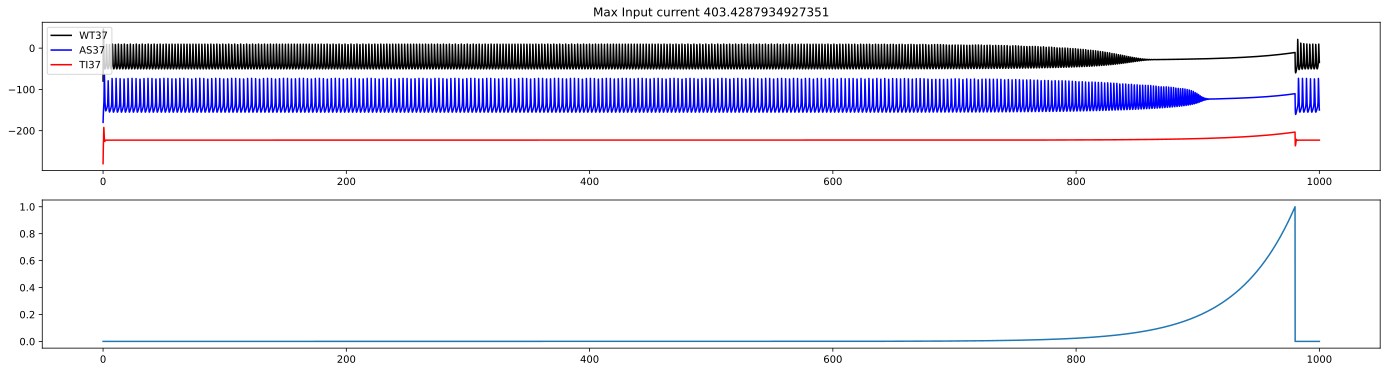

In [5]:
set_matplotlib_formats('svg')
if whichplot == 'ramp': plot_timeseries(Vy, i_scl, ctyp, paradigm=paradigm)
if whichplot == 'bifurcation': plot_bifurcation(Vy_fwd, Vy_bwd, I_fwd, I_bwd, ctyp, direction=[0,1])
if whichplot == 'phasespace': plot_phasespace(Vy, I_scl, ctyp, ['m_Na', 'h_Na'], Nplots = 50)

plt.savefig(whichplot+'.pdf')
files.download(whichplot+'.pdf')


In [0]:
np.intersect1d(np.where(np.log(I_scl) > -1)[0], np.where(np.log(I_scl) < 1)[0])

array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74])

In [0]:
len(Vy)

200